# PCA timepoints independently, and PCA timepoints against a common reference timepoint

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import seaborn as sns
import scanpy as sc
import genetools
from genetools.palette import HueValueStyle
from slugify import slugify
from covid_serology import config
from covid_serology.main import (
    transform_and_plot_pcas_multiple_timepoints_against_common_reference,
)
from covid_serology.pca import (
    pca_one_timepoint_against_reference,
    cleanup_adata,
)
from covid_serology.plots import plot_pca_one_hue_one_timepoint
from covid_serology.helpers import palette_dict

In [2]:
# Set fonts
from matplotlib import rc

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"], "size": 12})

In [3]:
# # view the params with:
# sns.plotting_context("paper",font_scale=1.25)

sns.set_context("paper", font_scale=1.25)

In [4]:
sc.settings.verbosity = 3

## Load datasets
Timepoints are concatenated horizontally. Use "timepoint" annotation in adata.var to separate out.

Rows are subjects. Columns are measurements defined as `(virus, target, variant_plate_type, antibody, timepoint)` tuples. Given a measurement at a timepoint: the same measurement at a different timepoint will be stored in a different column.

In [5]:
adata_all = sc.read(f"{config.paths.generated_data_dir}/combined_data.h5")
adata_all

AnnData object with n_obs × n_vars = 401 × 284
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months'
    var: 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'combined_name'

In [6]:
adata_all.obs

,Timepoint,First_dose_vaccine,Second_dose_vaccine,Status,source_cohort,Death,Variant,Vaccine,COVID Positive Ever?,Exposure,...,cutoff_column_to_check,any_p11_cutoffs_violated,any_p11_cutoffs_violated:boostD1/2,any_p11_cutoffs_violated:boostD21,any_p11_cutoffs_violated:boostD7/8,any_p11_cutoffs_violated:day 0 / pre-pandemic,any_p11_cutoffs_violated:day 21 / weeks 2&3,any_p11_cutoffs_violated:day 210 / 7 months,any_p11_cutoffs_violated:day 28 / week 4,any_p11_cutoffs_violated:week 7 and later / 3 months
mong0153,75.0,Sputnik V,Sputnik V,Sputnik V-Sputnik V,Mongolia_vaccine_variant_plate,NaN,NaN,NaN,NaN,Sputnik V-Sputnik V,...,Wuhan,False,False,False,False,False,False,False,False,False
mong0156,70.0,Sinopharm,Sinopharm,Sinopharm-Sinopharm,Mongolia_vaccine_variant_plate,NaN,NaN,NaN,NaN,Sinopharm-Sinopharm,...,Wuhan,True,False,False,False,False,False,False,False,True
mong0184,65.0,Sinopharm,Sinopharm,Sinopharm-Sinopharm,Mongolia_vaccine_variant_plate,NaN,NaN,NaN,NaN,Sinopharm-Sinopharm,...,Wuhan,True,False,False,False,False,False,False,False,True
mong0185,63.0,Sinopharm,Sinopharm,Sinopharm-Sinopharm,Mongolia_vaccine_variant_plate,NaN,NaN,NaN,NaN,Sinopharm-Sinopharm,...,Wuhan,True,False,False,False,False,False,False,False,True
mong0190,69.0,Sinopharm,Sinopharm,Sinopharm-Sinopharm,Mongolia_vaccine_variant_plate,NaN,NaN,NaN,NaN,Sinopharm-Sinopharm,...,Wuhan,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cohort2-0095,NaN,NaN,NaN,Mild,infection_cohort2_all,NaN,NaN,NaN,NaN,Wuhan Infection - Mild,...,Wuhan,False,False,False,False,False,False,False,False,False
cohort2-0098,NaN,NaN,NaN,Mild,infection_cohort2_all,NaN,NaN,NaN,NaN,Wuhan Infection - Mild,...,Wuhan,False,False,False,False,False,False,False,False,False
cohort2-0101,NaN,NaN,NaN,Critical,infection_cohort2_all,NaN,NaN,NaN,NaN,Wuhan Infection - Severe,...,Wuhan,False,False,False,False,False,False,False,False,False
cohort2-0198,NaN,NaN,NaN,Mild,infection_cohort2_all,NaN,NaN,NaN,NaN,Wuhan Infection - Mild,...,Wuhan,False,False,False,False,False,False,False,False,False


In [7]:
adata_all.var

,virus,target,variant_plate_type,antibody,timepoint,combined_name
varname,,,,,,
Epsilon_RBD_Variant_IgG_week 7 and later / 3 months,Epsilon,RBD,Variant,IgG,week 7 and later / 3 months,Epsilon_RBD_Variant_IgG_week 7 and later / 3 m...
Beta_RBD_Variant_IgG_week 7 and later / 3 months,Beta,RBD,Variant,IgG,week 7 and later / 3 months,Beta_RBD_Variant_IgG_week 7 and later / 3 months
Iota_RBD_Variant_IgG_week 7 and later / 3 months,Iota,RBD,Variant,IgG,week 7 and later / 3 months,Iota_RBD_Variant_IgG_week 7 and later / 3 months
Gamma_RBD_Variant_IgG_week 7 and later / 3 months,Gamma,RBD,Variant,IgG,week 7 and later / 3 months,Gamma_RBD_Variant_IgG_week 7 and later / 3 months
B.1.526.2_RBD_Variant_IgG_week 7 and later / 3 months,B.1.526.2,RBD,Variant,IgG,week 7 and later / 3 months,B.1.526.2_RBD_Variant_IgG_week 7 and later / 3...
...,...,...,...,...,...,...
Alpha_RBD_Variant_IgG_boostD21,Alpha,RBD,Variant,IgG,boostD21,Alpha_RBD_Variant_IgG_boostD21
P.3_RBD_Variant_IgG_boostD21,P.3,RBD,Variant,IgG,boostD21,P.3_RBD_Variant_IgG_boostD21
Kappa_RBD_Variant_IgG_boostD21,Kappa,RBD,Variant,IgG,boostD21,Kappa_RBD_Variant_IgG_boostD21


In [8]:
adata_variant_ratios = sc.read(f"{config.paths.generated_data_dir}/variant_ratios.h5")
adata_variant_ratios

AnnData object with n_obs × n_vars = 401 × 72
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months'
    var: 'denominator', 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'numerator'

In [9]:
adata_variant_ratios.obs["source_cohort"].value_counts()

Mongolia_vaccine_variant_plate    131
infection_cohort1                  99
infection_cohort2_all              74
Pfizer_all                         60
variant_infections                 37
Name: source_cohort, dtype: int64

In [10]:
# Remove any subjects that now have NaNs for all variables
# These will be any samples that have no variant ratio measurements
sc.pp.filter_cells(adata_variant_ratios, min_genes=1)

adata_variant_ratios.shape

filtered out 106 cells that have less than 1 genes expressed


(295, 72)

In [11]:
adata_variant_ratios.obs["source_cohort"].value_counts()

Mongolia_vaccine_variant_plate    131
infection_cohort2_all              74
Pfizer_all                         53
variant_infections                 37
Name: source_cohort, dtype: int64

In [12]:
adata_coronavirus_plate_subset = sc.read(
    f"{config.paths.generated_data_dir}/coronavirus_plate_only.subset.h5"
)
adata_coronavirus_plate_subset

AnnData object with n_obs × n_vars = 158 × 135
    obs: 'COVID Positive Ever?', 'Status', 'source_cohort', 'Death', 'Exposure', 'Exposure Type'
    var: 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint'

In [13]:
adata_coronavirus_plate_subset.obs

,COVID Positive Ever?,Status,source_cohort,Death,Exposure,Exposure Type
pfizer00,No,Vaccinee,Pfizer_vaccine,NaN,Pfizer-Pfizer (Stanford),Pfizer-Pfizer (Stanford)
pfizer01,No,Vaccinee,Pfizer_vaccine,NaN,Pfizer-Pfizer (Stanford),Pfizer-Pfizer (Stanford)
pfizer02,No,Vaccinee,Pfizer_vaccine,NaN,Pfizer-Pfizer (Stanford),Pfizer-Pfizer (Stanford)
pfizer03,No,Vaccinee,Pfizer_vaccine,NaN,Pfizer-Pfizer (Stanford),Pfizer-Pfizer (Stanford)
pfizer04,No,Vaccinee,Pfizer_vaccine,NaN,Pfizer-Pfizer (Stanford),Pfizer-Pfizer (Stanford)
...,...,...,...,...,...,...
84,NaN,ICU,infection_cohort1,0.0,Wuhan Infection - ICU,Infection
87,NaN,ICU,infection_cohort1,0.0,Wuhan Infection - ICU,Infection
101,NaN,Admit,infection_cohort1,0.0,Wuhan Infection - Admit,Infection
6,NaN,ICU,infection_cohort1,1.0,Wuhan Infection - ICU,Infection


In [14]:
adata_coronavirus_plate_subset.var

,virus,target,variant_plate_type,antibody,timepoint
varname,,,,,
Wuhan_S_Wuhan_IgG_day 0 / pre-pandemic,Wuhan,S,Wuhan,IgG,day 0 / pre-pandemic
NL63_S_Wuhan_IgG_day 0 / pre-pandemic,NL63,S,Wuhan,IgG,day 0 / pre-pandemic
Wuhan_N_Wuhan_IgG_day 0 / pre-pandemic,Wuhan,N,Wuhan,IgG,day 0 / pre-pandemic
CoV1_S_Wuhan_IgG_day 0 / pre-pandemic,CoV1,S,Wuhan,IgG,day 0 / pre-pandemic
Wuhan_NTD_Wuhan_IgG_day 0 / pre-pandemic,Wuhan,NTD,Wuhan,IgG,day 0 / pre-pandemic
...,...,...,...,...,...
Wuhan_NTD_Wuhan_IgA_day 42 / weeks 5&6,Wuhan,NTD,Wuhan,IgA,day 42 / weeks 5&6
HKU1_S_Wuhan_IgA_day 42 / weeks 5&6,HKU1,S,Wuhan,IgA,day 42 / weeks 5&6
OC43_S_Wuhan_IgA_day 42 / weeks 5&6,OC43,S,Wuhan,IgA,day 42 / weeks 5&6


In [15]:
# Filter to Wuhan/non-variant only
adata_coronavirus_plate_subset = adata_coronavirus_plate_subset[
    :, adata_coronavirus_plate_subset.var["variant_plate_type"] == "Wuhan"
].copy()
adata_coronavirus_plate_subset.var

,virus,target,variant_plate_type,antibody,timepoint
varname,,,,,
Wuhan_S_Wuhan_IgG_day 0 / pre-pandemic,Wuhan,S,Wuhan,IgG,day 0 / pre-pandemic
NL63_S_Wuhan_IgG_day 0 / pre-pandemic,NL63,S,Wuhan,IgG,day 0 / pre-pandemic
Wuhan_N_Wuhan_IgG_day 0 / pre-pandemic,Wuhan,N,Wuhan,IgG,day 0 / pre-pandemic
CoV1_S_Wuhan_IgG_day 0 / pre-pandemic,CoV1,S,Wuhan,IgG,day 0 / pre-pandemic
Wuhan_NTD_Wuhan_IgG_day 0 / pre-pandemic,Wuhan,NTD,Wuhan,IgG,day 0 / pre-pandemic
...,...,...,...,...,...
Wuhan_NTD_Wuhan_IgA_day 42 / weeks 5&6,Wuhan,NTD,Wuhan,IgA,day 42 / weeks 5&6
HKU1_S_Wuhan_IgA_day 42 / weeks 5&6,HKU1,S,Wuhan,IgA,day 42 / weeks 5&6
OC43_S_Wuhan_IgA_day 42 / weeks 5&6,OC43,S,Wuhan,IgA,day 42 / weeks 5&6


In [16]:
adata_coronavirus_plate_subset.obs["source_cohort"].value_counts()

infection_cohort1    99
Pfizer_vaccine       59
Name: source_cohort, dtype: int64

In [17]:
adata_coronavirus_plate_subset.shape

(158, 135)

In [18]:
# Remove any subjects that now have NaNs for all variables
# These will be any samples that have no standard coronavirus plate measurements, only variant ratios
sc.pp.filter_cells(adata_coronavirus_plate_subset, min_genes=1)

adata_coronavirus_plate_subset.shape

filtered out 1 cells that have less than 1 genes expressed


(157, 135)

In [19]:
adata_coronavirus_plate_subset.obs["source_cohort"].value_counts()

infection_cohort1    98
Pfizer_vaccine       59
Name: source_cohort, dtype: int64

### Choose timepoints

In [20]:
all_timepoints = set(adata_coronavirus_plate_subset.var["timepoint"]).union(
    adata_variant_ratios.var["timepoint"]
)
all_timepoints

{'boostD1/2',
 'boostD21',
 'boostD7/8',
 'day 0 / pre-pandemic',
 'day 21 / weeks 2&3',
 'day 210 / 7 months',
 'day 28 / week 4',
 'day 42 / weeks 5&6',
 'day 7 / week 1',
 'week 7 and later / 3 months'}

In [21]:
reference_timepoint_wuhan_comparison = config.reference_timepoint_wuhan_comparison
reference_timepoint_wuhan_comparison

'day 21 / weeks 2&3'

In [22]:
reference_timepoint_variant_comparison = config.reference_timepoint_variant_comparison
reference_timepoint_variant_comparison

'day 28 / week 4'

In [23]:
timepoint_sort_order = [
    "day 0 / pre-pandemic",
    "day 7 / week 1",
    "day 21 / weeks 2&3",
    "day 28 / week 4",
    "day 42 / weeks 5&6",
    "week 7 and later / 3 months",
    "day 210 / 7 months",
    "boostD1/2",
    "boostD21",
    "boostD7/8",
]
assert all(
    [timepoint in timepoint_sort_order for timepoint in all_timepoints]
), "Not all timepoints are represented in timepoint sort order"
timepoint_sort_order

['day 0 / pre-pandemic',
 'day 7 / week 1',
 'day 21 / weeks 2&3',
 'day 28 / week 4',
 'day 42 / weeks 5&6',
 'week 7 and later / 3 months',
 'day 210 / 7 months',
 'boostD1/2',
 'boostD21',
 'boostD7/8']

### Choose colors

In [24]:
discrete_colors_to_plot = [
    "Exposure",
    "Exposure Type",
]
# could add continuous hues here too

# (column name, continuous or not)
colors_to_plot = [(s, False) for s in discrete_colors_to_plot]
colors_to_plot

[('Exposure', False), ('Exposure Type', False)]

In [25]:
palette_dict.keys()

dict_keys(['Outpt / Admit', 'Infection', 'Wuhan Infection - Admit', 'Wuhan Infection - Moderate', 'ICU / Death', 'Control', 'Wuhan Infection - Outpatient', 'Wuhan Infection - Mild', 'Wuhan Infection - ICU', 'Wuhan Infection - Severe', 'Pfizer-Pfizer (Stanford)', 'Pfizer-Pfizer (Stanford), CoV2+', 'Sinopharm-Sinopharm', 'Sputnik V-Sputnik V', 'AstraZeneca-AstraZeneca', 'Pfizer-Pfizer (Mongolia)', 'Variant Infection - Alpha', 'Variant Infection - Delta'])

<AxesSubplot:>

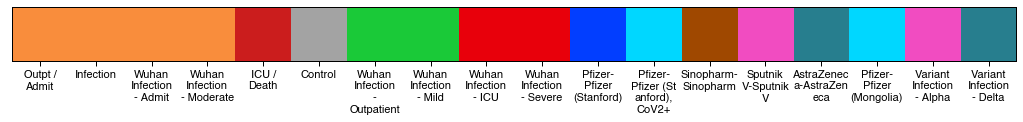

In [26]:
# visualize chosen colors
# first cast any HueValueStyle objects in the dict to be color strings only
palette_dict_colors_only = HueValueStyle.huestyles_to_colors_dict(palette_dict)

# modified palplot to have labels: https://stackoverflow.com/a/64492813 and https://github.com/mwaskom/seaborn/blob/cef0a2d5e86477a80659898e66bc2295886bf917/seaborn/miscplot.py#L9

import matplotlib.ticker as ticker
import matplotlib as mpl

n = len(palette_dict_colors_only)
size = 1

f, ax = plt.subplots(1, 1, figsize=(n * size, size))
ax.imshow(
    np.arange(n).reshape(1, n),
    cmap=mpl.colors.ListedColormap(list(palette_dict_colors_only.values())),
    interpolation="nearest",
    aspect="auto",
)
ax.set_xticks(np.arange(n) - 0.5)
ax.set_yticks([-0.5, 0.5])
# Ensure nice border between colors
ax.set_xticklabels(["" for _ in range(n)])

# Add labels to x-axis:
ax.set_xticks(np.arange(n))
ax.set_xticklabels(palette_dict_colors_only.keys(), ha="center")

# The proper way to set no ticks on y-axis
ax.yaxis.set_major_locator(ticker.NullLocator())

genetools.plots.wrap_tick_labels(ax, wrap_amount=10)

## CoV2 antigens, IgG, IgM, and IgA only, except N antigen

Using subset of data:

- `infection_cohort1`
- Pfizer vaccine data, original version (new version no longer has IgM or IgA data, only IgG)

In [27]:
adata_coronavirus_plate_subset

AnnData object with n_obs × n_vars = 157 × 135
    obs: 'COVID Positive Ever?', 'Status', 'source_cohort', 'Death', 'Exposure', 'Exposure Type', 'n_genes'
    var: 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint'

In [28]:
adata_coronavirus_plate_subset.obs["source_cohort"].value_counts()

infection_cohort1    98
Pfizer_vaccine       59
Name: source_cohort, dtype: int64

In [29]:
adata_coronavirus_plate_subset.var

,virus,target,variant_plate_type,antibody,timepoint
varname,,,,,
Wuhan_S_Wuhan_IgG_day 0 / pre-pandemic,Wuhan,S,Wuhan,IgG,day 0 / pre-pandemic
NL63_S_Wuhan_IgG_day 0 / pre-pandemic,NL63,S,Wuhan,IgG,day 0 / pre-pandemic
Wuhan_N_Wuhan_IgG_day 0 / pre-pandemic,Wuhan,N,Wuhan,IgG,day 0 / pre-pandemic
CoV1_S_Wuhan_IgG_day 0 / pre-pandemic,CoV1,S,Wuhan,IgG,day 0 / pre-pandemic
Wuhan_NTD_Wuhan_IgG_day 0 / pre-pandemic,Wuhan,NTD,Wuhan,IgG,day 0 / pre-pandemic
...,...,...,...,...,...
Wuhan_NTD_Wuhan_IgA_day 42 / weeks 5&6,Wuhan,NTD,Wuhan,IgA,day 42 / weeks 5&6
HKU1_S_Wuhan_IgA_day 42 / weeks 5&6,HKU1,S,Wuhan,IgA,day 42 / weeks 5&6
OC43_S_Wuhan_IgA_day 42 / weeks 5&6,OC43,S,Wuhan,IgA,day 42 / weeks 5&6


In [30]:
_ = transform_and_plot_pcas_multiple_timepoints_against_common_reference(
    adata=adata_coronavirus_plate_subset[
        :,
        (adata_coronavirus_plate_subset.var["virus"] == "Wuhan")
        & (adata_coronavirus_plate_subset.var["target"] != "N"),
    ],
    plot_name="cov2_all_except_N",
    palette_dict=palette_dict,
    colors_to_plot=colors_to_plot,
    reference_timepoint=reference_timepoint_wuhan_comparison,
    timepoint_sort_order=timepoint_sort_order,
)

filtered out 24 cells that have less than 9 genes expressed


filtered out 105 cells that have less than 9 genes expressed


filtered out 67 cells that have less than 9 genes expressed


Fewer than two source cohorts for timepoint day 0 / pre-pandemic - skipping.


filtered out 24 cells that have less than 9 genes expressed


filtered out 80 cells that have less than 9 genes expressed


filtered out 76 cells that have less than 9 genes expressed


## Time course PCA of variant ratios for `infection_cohort2` patients and Pfizer vaccinees AND variant infections
at each timepoint, only choose subjects who don't violate any p11 cutoffs at that timepoint.

In [31]:
adata_variant_ratios.obs["source_cohort"].value_counts()

Mongolia_vaccine_variant_plate    131
infection_cohort2_all              74
Pfizer_all                         53
variant_infections                 37
Name: source_cohort, dtype: int64

In [32]:
# subset to cohorts
adata_variant_ratios_time_course_with_variant_infections = adata_variant_ratios[
    adata_variant_ratios.obs["source_cohort"].isin(
        ["infection_cohort2_all", "Pfizer_all", "variant_infections"]
    )
].copy()
adata_variant_ratios_time_course_with_variant_infections.obs["Status"].value_counts()

Mild                                           58
Vaccinee                                       53
Variant Infection - Delta                      21
Variant Infection - Delta - mRNA vaccinated    12
Critical                                        7
Moderate                                        6
Variant Infection - Alpha                       4
Severe                                          2
Asymptomatic                                    1
Name: Status, dtype: int64

In [33]:
adata_variant_ratios_time_course_with_variant_infections

AnnData object with n_obs × n_vars = 164 × 72
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months', 'n_genes'
    var: 'denominator', 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'numerator'

In [34]:
# also subset to not being a breakthrough infection
adata_variant_ratios_time_course_with_variant_infections = (
    adata_variant_ratios_time_course_with_variant_infections[
        adata_variant_ratios_time_course_with_variant_infections.obs["Status"]
        != "Variant Infection - Delta - mRNA vaccinated"
    ].copy()
)
adata_variant_ratios_time_course_with_variant_infections.obs["Status"].value_counts()

Mild                         58
Vaccinee                     53
Variant Infection - Delta    21
Critical                      7
Moderate                      6
Variant Infection - Alpha     4
Severe                        2
Asymptomatic                  1
Name: Status, dtype: int64

In [35]:
adata_variant_ratios_time_course_with_variant_infections

AnnData object with n_obs × n_vars = 152 × 72
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months', 'n_genes'
    var: 'denominator', 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'numerator'

In [36]:
adata_variant_ratios_time_course_with_variant_infections.obs[
    "any_p11_cutoffs_violated"
].value_counts()

False    90
True     62
Name: any_p11_cutoffs_violated, dtype: int64

In [37]:
# timepoint specific cutoffs violated columns:
adata_variant_ratios_time_course_with_variant_infections.obs[
    "any_p11_cutoffs_violated:day 28 / week 4"
].value_counts()

False    149
True       3
Name: any_p11_cutoffs_violated:day 28 / week 4, dtype: int64

In [38]:
adata_variant_ratios_time_course_with_variant_infections.var

,denominator,virus,target,variant_plate_type,antibody,timepoint,numerator
combined_name,,,,,,,
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:Epsilon_RBD_Variant_IgG_boostD1/2,Epsilon_RBD_Variant_IgG_boostD1/2,Epsilon,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:Beta_RBD_Variant_IgG_boostD1/2,Beta_RBD_Variant_IgG_boostD1/2,Beta,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:Iota_RBD_Variant_IgG_boostD1/2,Iota_RBD_Variant_IgG_boostD1/2,Iota,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:Gamma_RBD_Variant_IgG_boostD1/2,Gamma_RBD_Variant_IgG_boostD1/2,Gamma,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:B.1.526.2_RBD_Variant_IgG_boostD1/2,B.1.526.2_RBD_Variant_IgG_boostD1/2,B.1.526.2,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
...,...,...,...,...,...,...,...
ratio:Wuhan_RBD_Variant_IgG_week 7 and later / 3 months:B.1.526.2_RBD_Variant_IgG_week 7 and later / 3 months,B.1.526.2_RBD_Variant_IgG_week 7 and later / 3...,B.1.526.2,RBD,Variant,IgG,week 7 and later / 3 months,Wuhan_RBD_Variant_IgG_week 7 and later / 3 months
ratio:Wuhan_RBD_Variant_IgG_week 7 and later / 3 months:Alpha_RBD_Variant_IgG_week 7 and later / 3 months,Alpha_RBD_Variant_IgG_week 7 and later / 3 months,Alpha,RBD,Variant,IgG,week 7 and later / 3 months,Wuhan_RBD_Variant_IgG_week 7 and later / 3 months
ratio:Wuhan_RBD_Variant_IgG_week 7 and later / 3 months:P.3_RBD_Variant_IgG_week 7 and later / 3 months,P.3_RBD_Variant_IgG_week 7 and later / 3 months,P.3,RBD,Variant,IgG,week 7 and later / 3 months,Wuhan_RBD_Variant_IgG_week 7 and later / 3 months


In [39]:
adata_variant_ratios_time_course_with_variant_infections_figure_data = (
    transform_and_plot_pcas_multiple_timepoints_against_common_reference(
        adata=adata_variant_ratios_time_course_with_variant_infections,
        plot_name="variants_with_variant_infections",
        palette_dict=palette_dict,
        colors_to_plot=colors_to_plot,
        reference_timepoint=reference_timepoint_variant_comparison,
        enforce_cutoffs=True,
        timepoint_sort_order=timepoint_sort_order,
    )
)

filtered out 60 cells that have less than 9 genes expressed


filtered out 130 cells that have less than 9 genes expressed


filtered out 137 cells that have less than 9 genes expressed


filtered out 149 cells that have less than 9 genes expressed


filtered out 109 cells that have less than 9 genes expressed


Timepoint boostD1/2: removing 3 rows due to plate 11 cutoffs.
Fewer than two source cohorts for timepoint boostD1/2 - skipping.
Timepoint boostD7/8: removing 0 rows due to plate 11 cutoffs.
Fewer than two source cohorts for timepoint boostD7/8 - skipping.
Timepoint boostD21: removing 0 rows due to plate 11 cutoffs.
Fewer than two source cohorts for timepoint boostD21 - skipping.
Timepoint day 0 / pre-pandemic: removing 41 rows due to plate 11 cutoffs.


filtered out 92 cells that have less than 9 genes expressed


Fewer than two source cohorts for timepoint day 0 / pre-pandemic - skipping.
Timepoint day 21 / weeks 2&3: removing 7 rows due to plate 11 cutoffs.


filtered out 60 cells that have less than 9 genes expressed


Timepoint day 28 / week 4: removing 3 rows due to plate 11 cutoffs.


filtered out 95 cells that have less than 9 genes expressed


Timepoint day 210 / 7 months: removing 11 rows due to plate 11 cutoffs.


filtered out 88 cells that have less than 9 genes expressed


Timepoint week 7 and later / 3 months: removing 6 rows due to plate 11 cutoffs.


### Export exactly the samples that are in the figure (i.e. passed cutoffs)

In [40]:
adata_variant_ratios_time_course_with_variant_infections_figure_data

[('day 21 / weeks 2&3',
  AnnData object with n_obs × n_vars = 53 × 9
      obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months', 'n_genes'
      var: 'denominator', 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'numerator', 'n_cells'
      uns: 'pca'
      obsm: 'X_pca'
      varm: 'PCs'),
 ('day 28 / week 4',
  AnnData object with n_obs × n_vars = 89 × 9
      obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_coho

In [41]:
# reformat as dict
adata_variant_ratios_time_course_with_variant_infections_figure_data = {
    timepoint: timepoint_adata_pcaed
    for (
        timepoint,
        timepoint_adata_pcaed,
    ) in adata_variant_ratios_time_course_with_variant_infections_figure_data
}
adata_variant_ratios_time_course_with_variant_infections_figure_data.keys()

dict_keys(['day 21 / weeks 2&3', 'day 28 / week 4', 'week 7 and later / 3 months', 'day 210 / 7 months'])

In [42]:
# get raw data (pre-transforms) for reference timepoint
fig_s5b_adata = adata_variant_ratios_time_course_with_variant_infections_figure_data[
    reference_timepoint_variant_comparison
].raw.to_adata()
fig_s5b_adata

AnnData object with n_obs × n_vars = 89 × 9
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months', 'n_genes'
    var: 'denominator', 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'numerator', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'

Alternatively you could use:

```
fig_s5b_adata = adata_variant_ratios_time_course_with_variant_infections[
    adata_variant_ratios_time_course_with_variant_infections.obs[
        f"any_p11_cutoffs_violated:{reference_timepoint_variant_comparison}"
    ]
    == False,
    adata_variant_ratios_time_course_with_variant_infections.var["timepoint"]
    == reference_timepoint_variant_comparison,
]
fig_s5b_adata = cleanup_adata(fig_s5b_adata)
```

But that's more error-prone. Let's let the main plotting code handle that logic for us


Continue with the export:

In [43]:
fig_s5b_df = fig_s5b_adata.to_df()
fig_s5b_df

combined_name,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Epsilon_RBD_Variant_IgG_day 28 / week 4,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Beta_RBD_Variant_IgG_day 28 / week 4,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Iota_RBD_Variant_IgG_day 28 / week 4,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Gamma_RBD_Variant_IgG_day 28 / week 4,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:B.1.526.2_RBD_Variant_IgG_day 28 / week 4,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Alpha_RBD_Variant_IgG_day 28 / week 4,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:P.3_RBD_Variant_IgG_day 28 / week 4,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Kappa_RBD_Variant_IgG_day 28 / week 4,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Delta_RBD_Variant_IgG_day 28 / week 4
VariantInfection_7,1.601440,6.132034,4.706114,2.938164,1.134944,0.415594,3.052104,2.380566,2.604134
VariantInfection_8,1.183153,2.875798,3.049274,1.530528,0.951611,0.566536,3.310914,1.864031,1.745396
VariantInfection_10,1.280355,2.237505,1.614093,1.458479,1.155455,0.897777,1.529394,1.242949,1.637570
VariantInfection_11,0.603125,4.124524,1.992277,2.399200,1.245564,1.526420,3.590779,0.761188,0.443932
VariantInfection_33,0.356768,10.908671,1.664127,6.176074,1.197118,3.703083,8.448293,0.469692,0.203085
...,...,...,...,...,...,...,...,...,...
cohort2-0212,1.565133,8.064258,4.296547,4.050503,1.138574,1.502563,8.151688,2.103962,2.432643
cohort2-0215,1.273267,5.295394,2.617568,2.599772,1.138264,1.754188,5.523726,1.568963,1.718973
cohort2-0218,4.249776,14.282390,9.049357,8.737440,1.106709,2.275734,13.847960,4.874630,5.321623
cohort2-0219,0.954939,4.808152,2.647341,2.976427,1.213674,1.779617,4.945816,1.222828,1.262787


In [44]:
fig_s5b_df.isna().any()

combined_name
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Epsilon_RBD_Variant_IgG_day 28 / week 4      False
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Beta_RBD_Variant_IgG_day 28 / week 4         False
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Iota_RBD_Variant_IgG_day 28 / week 4         False
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Gamma_RBD_Variant_IgG_day 28 / week 4        False
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:B.1.526.2_RBD_Variant_IgG_day 28 / week 4    False
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Alpha_RBD_Variant_IgG_day 28 / week 4        False
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:P.3_RBD_Variant_IgG_day 28 / week 4          False
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Kappa_RBD_Variant_IgG_day 28 / week 4        False
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Delta_RBD_Variant_IgG_day 28 / week 4        False
dtype: bool

In [45]:
# Reshape
fig_s5b_df = pd.melt(
    fig_s5b_df.reset_index(),
    id_vars=["index"],
    var_name="var_name",
    value_name="ratio_value",
).rename(columns={"index": "participant"})
fig_s5b_df

,participant,var_name,ratio_value
0,VariantInfection_7,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,1.601440
1,VariantInfection_8,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,1.183153
2,VariantInfection_10,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,1.280355
3,VariantInfection_11,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,0.603125
4,VariantInfection_33,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,0.356768
...,...,...,...
796,cohort2-0212,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,2.432643
797,cohort2-0215,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,1.718973
798,cohort2-0218,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,5.321623
799,cohort2-0219,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,1.262787


In [46]:
fig_s5b_df["var_name"].nunique()

9

In [47]:
fig_s5b_adata.obs["Exposure"]

VariantInfection_7     Variant Infection - Alpha
VariantInfection_8     Variant Infection - Alpha
VariantInfection_10    Variant Infection - Alpha
VariantInfection_11    Variant Infection - Delta
VariantInfection_33    Variant Infection - Delta
                                 ...            
cohort2-0212              Wuhan Infection - Mild
cohort2-0215            Wuhan Infection - Severe
cohort2-0218              Wuhan Infection - Mild
cohort2-0219              Wuhan Infection - Mild
cohort2-0222              Wuhan Infection - Mild
Name: Exposure, Length: 89, dtype: category
Categories (7, object): ['Pfizer-Pfizer (Stanford)', 'Pfizer-Pfizer (Stanford), CoV2+', 'Variant Infection - Alpha', 'Variant Infection - Delta', 'Wuhan Infection - Mild', 'Wuhan Infection - Moderate', 'Wuhan Infection - Severe']

In [48]:
# Merge in Exposure
fig_s5b_df = pd.merge(
    fig_s5b_df,
    fig_s5b_adata.obs["Exposure"].rename("exposure"),
    left_on="participant",
    right_index=True,
    validate="m:1",
    how="left",
)
assert not fig_s5b_df["exposure"].isna().any(), "merge failed"
fig_s5b_df

,participant,var_name,ratio_value,exposure
0,VariantInfection_7,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,1.601440,Variant Infection - Alpha
1,VariantInfection_8,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,1.183153,Variant Infection - Alpha
2,VariantInfection_10,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,1.280355,Variant Infection - Alpha
3,VariantInfection_11,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,0.603125,Variant Infection - Delta
4,VariantInfection_33,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,0.356768,Variant Infection - Delta
...,...,...,...,...
796,cohort2-0212,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,2.432643,Wuhan Infection - Mild
797,cohort2-0215,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,1.718973,Wuhan Infection - Severe
798,cohort2-0218,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,5.321623,Wuhan Infection - Mild
799,cohort2-0219,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,1.262787,Wuhan Infection - Mild


In [49]:
fig_s5b_adata.var

,denominator,virus,target,variant_plate_type,antibody,timepoint,numerator,n_cells
combined_name,,,,,,,,
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Epsilon_RBD_Variant_IgG_day 28 / week 4,Epsilon_RBD_Variant_IgG_day 28 / week 4,Epsilon,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4,89
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Beta_RBD_Variant_IgG_day 28 / week 4,Beta_RBD_Variant_IgG_day 28 / week 4,Beta,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4,89
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Iota_RBD_Variant_IgG_day 28 / week 4,Iota_RBD_Variant_IgG_day 28 / week 4,Iota,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4,89
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Gamma_RBD_Variant_IgG_day 28 / week 4,Gamma_RBD_Variant_IgG_day 28 / week 4,Gamma,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4,89
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:B.1.526.2_RBD_Variant_IgG_day 28 / week 4,B.1.526.2_RBD_Variant_IgG_day 28 / week 4,B.1.526.2,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4,89
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Alpha_RBD_Variant_IgG_day 28 / week 4,Alpha_RBD_Variant_IgG_day 28 / week 4,Alpha,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4,89
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:P.3_RBD_Variant_IgG_day 28 / week 4,P.3_RBD_Variant_IgG_day 28 / week 4,P.3,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4,89
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Kappa_RBD_Variant_IgG_day 28 / week 4,Kappa_RBD_Variant_IgG_day 28 / week 4,Kappa,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4,89
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Delta_RBD_Variant_IgG_day 28 / week 4,Delta_RBD_Variant_IgG_day 28 / week 4,Delta,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4,89


In [50]:
# Merge in var info
fig_s5b_df = pd.merge(
    fig_s5b_df,
    fig_s5b_adata.var.drop("n_cells", axis=1),
    left_on="var_name",
    right_index=True,
    validate="m:1",
    how="left",
)
assert not fig_s5b_df["numerator"].isna().any(), "merge failed"
fig_s5b_df

,participant,var_name,ratio_value,exposure,denominator,virus,target,variant_plate_type,antibody,timepoint,numerator
0,VariantInfection_7,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,1.601440,Variant Infection - Alpha,Epsilon_RBD_Variant_IgG_day 28 / week 4,Epsilon,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4
1,VariantInfection_8,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,1.183153,Variant Infection - Alpha,Epsilon_RBD_Variant_IgG_day 28 / week 4,Epsilon,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4
2,VariantInfection_10,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,1.280355,Variant Infection - Alpha,Epsilon_RBD_Variant_IgG_day 28 / week 4,Epsilon,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4
3,VariantInfection_11,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,0.603125,Variant Infection - Delta,Epsilon_RBD_Variant_IgG_day 28 / week 4,Epsilon,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4
4,VariantInfection_33,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Ep...,0.356768,Variant Infection - Delta,Epsilon_RBD_Variant_IgG_day 28 / week 4,Epsilon,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4
...,...,...,...,...,...,...,...,...,...,...,...
796,cohort2-0212,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,2.432643,Wuhan Infection - Mild,Delta_RBD_Variant_IgG_day 28 / week 4,Delta,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4
797,cohort2-0215,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,1.718973,Wuhan Infection - Severe,Delta_RBD_Variant_IgG_day 28 / week 4,Delta,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4
798,cohort2-0218,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,5.321623,Wuhan Infection - Mild,Delta_RBD_Variant_IgG_day 28 / week 4,Delta,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4
799,cohort2-0219,ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:De...,1.262787,Wuhan Infection - Mild,Delta_RBD_Variant_IgG_day 28 / week 4,Delta,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4


In [51]:
# Reorder and simplify
fig_s5b_df = fig_s5b_df.rename(columns={"virus": "ratio_denominator_strain"}).assign(
    ratio_numerator_strain="Wuhan"
)
fig_s5b_df = fig_s5b_df[
    [
        "participant",
        "exposure",
        "timepoint",
        "ratio_numerator_strain",
        "ratio_denominator_strain",
        "ratio_value",
    ]
]
fig_s5b_df = fig_s5b_df.sort_values(["participant", "ratio_denominator_strain"])
fig_s5b_df

,participant,exposure,timepoint,ratio_numerator_strain,ratio_denominator_strain,ratio_value
447,VariantInfection_10,Variant Infection - Alpha,day 28 / week 4,Wuhan,Alpha,0.897777
358,VariantInfection_10,Variant Infection - Alpha,day 28 / week 4,Wuhan,B.1.526.2,1.155455
91,VariantInfection_10,Variant Infection - Alpha,day 28 / week 4,Wuhan,Beta,2.237505
714,VariantInfection_10,Variant Infection - Alpha,day 28 / week 4,Wuhan,Delta,1.637570
2,VariantInfection_10,Variant Infection - Alpha,day 28 / week 4,Wuhan,Epsilon,1.280355
...,...,...,...,...,...,...
68,pfizer58,Pfizer-Pfizer (Stanford),day 28 / week 4,Wuhan,Epsilon,0.680162
335,pfizer58,Pfizer-Pfizer (Stanford),day 28 / week 4,Wuhan,Gamma,1.442542
246,pfizer58,Pfizer-Pfizer (Stanford),day 28 / week 4,Wuhan,Iota,1.326553
691,pfizer58,Pfizer-Pfizer (Stanford),day 28 / week 4,Wuhan,Kappa,0.828217


In [52]:
fig_s5b_df.to_csv(
    f"{config.paths.output_dir}/fig_s5b_data_export.tsv", sep="\t", index=None
)

## Day 90 variant ratios for `infection_cohort2` patients, Pfizer vaccinees, Mongolia vaccinees. Without vaccinees who are CoV2+

In [53]:
adata_variant_ratios.obs["source_cohort"].value_counts()

Mongolia_vaccine_variant_plate    131
infection_cohort2_all              74
Pfizer_all                         53
variant_infections                 37
Name: source_cohort, dtype: int64

In [54]:
# subset cohorts
adata_variant_ratios_day90 = adata_variant_ratios[
    adata_variant_ratios.obs["source_cohort"] != "infection_cohort1"
].copy()
adata_variant_ratios_day90.obs["Exposure Type"].value_counts()

Infection                                      99
Pfizer-Pfizer (Stanford)                       49
AstraZeneca-AstraZeneca                        37
Sinopharm-Sinopharm                            36
Sputnik V-Sputnik V                            33
Pfizer-Pfizer (Mongolia)                       25
Variant Infection - Delta - mRNA vaccinated    12
Pfizer-Pfizer (Stanford), CoV2+                 4
Name: Exposure Type, dtype: int64

In [55]:
adata_variant_ratios_day90

AnnData object with n_obs × n_vars = 295 × 72
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months', 'n_genes'
    var: 'denominator', 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'numerator'

In [56]:
# filter out breakthrough infections or past infections before vaccination

adata_variant_ratios_day90 = adata_variant_ratios_day90[
    ~adata_variant_ratios_day90.obs["Exposure Type"].isin(
        [
            "Pfizer-Pfizer (Stanford), CoV2+",
            "Variant Infection - Delta - mRNA vaccinated",
        ]
    )
].copy()

adata_variant_ratios_day90.obs["Exposure Type"].value_counts()

Infection                   99
Pfizer-Pfizer (Stanford)    49
AstraZeneca-AstraZeneca     37
Sinopharm-Sinopharm         36
Sputnik V-Sputnik V         33
Pfizer-Pfizer (Mongolia)    25
Name: Exposure Type, dtype: int64

In [57]:
adata_variant_ratios_day90

AnnData object with n_obs × n_vars = 279 × 72
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months', 'n_genes'
    var: 'denominator', 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'numerator'

In [58]:
adata_variant_ratios_day90.var

,denominator,virus,target,variant_plate_type,antibody,timepoint,numerator
combined_name,,,,,,,
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:Epsilon_RBD_Variant_IgG_boostD1/2,Epsilon_RBD_Variant_IgG_boostD1/2,Epsilon,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:Beta_RBD_Variant_IgG_boostD1/2,Beta_RBD_Variant_IgG_boostD1/2,Beta,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:Iota_RBD_Variant_IgG_boostD1/2,Iota_RBD_Variant_IgG_boostD1/2,Iota,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:Gamma_RBD_Variant_IgG_boostD1/2,Gamma_RBD_Variant_IgG_boostD1/2,Gamma,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
ratio:Wuhan_RBD_Variant_IgG_boostD1/2:B.1.526.2_RBD_Variant_IgG_boostD1/2,B.1.526.2_RBD_Variant_IgG_boostD1/2,B.1.526.2,RBD,Variant,IgG,boostD1/2,Wuhan_RBD_Variant_IgG_boostD1/2
...,...,...,...,...,...,...,...
ratio:Wuhan_RBD_Variant_IgG_week 7 and later / 3 months:B.1.526.2_RBD_Variant_IgG_week 7 and later / 3 months,B.1.526.2_RBD_Variant_IgG_week 7 and later / 3...,B.1.526.2,RBD,Variant,IgG,week 7 and later / 3 months,Wuhan_RBD_Variant_IgG_week 7 and later / 3 months
ratio:Wuhan_RBD_Variant_IgG_week 7 and later / 3 months:Alpha_RBD_Variant_IgG_week 7 and later / 3 months,Alpha_RBD_Variant_IgG_week 7 and later / 3 months,Alpha,RBD,Variant,IgG,week 7 and later / 3 months,Wuhan_RBD_Variant_IgG_week 7 and later / 3 months
ratio:Wuhan_RBD_Variant_IgG_week 7 and later / 3 months:P.3_RBD_Variant_IgG_week 7 and later / 3 months,P.3_RBD_Variant_IgG_week 7 and later / 3 months,P.3,RBD,Variant,IgG,week 7 and later / 3 months,Wuhan_RBD_Variant_IgG_week 7 and later / 3 months


In [59]:
adata_variant_ratios_day90.var["timepoint"].value_counts()

boostD1/2                      9
boostD7/8                      9
boostD21                       9
day 0 / pre-pandemic           9
day 21 / weeks 2&3             9
day 28 / week 4                9
day 210 / 7 months             9
week 7 and later / 3 months    9
Name: timepoint, dtype: int64

filtered out 88 cells that have less than 9 genes expressed


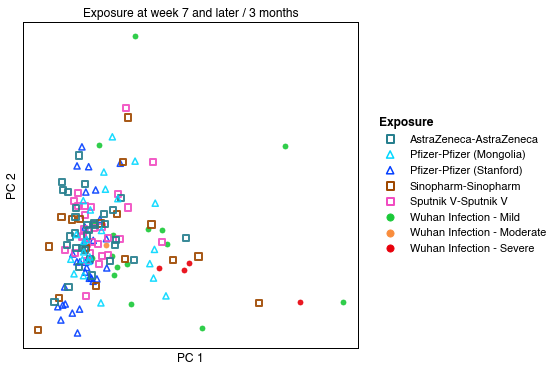

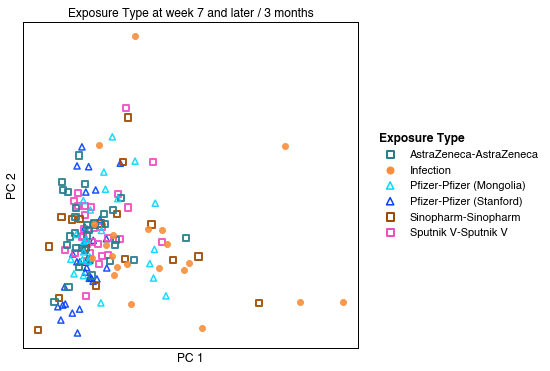

In [60]:
timepoint = "week 7 and later / 3 months"
plot_name = "variant_ratios_all_groups_day90"

# convert plot name to valid filename
output_prefix = slugify(f"{plot_name}.{timepoint}")

adata_subset = adata_variant_ratios_day90[
    adata_variant_ratios_day90.obs[f"any_p11_cutoffs_violated:{timepoint}"] == False,
    adata_variant_ratios_day90.var["timepoint"] == timepoint,
]
adata_subset = cleanup_adata(adata_subset)
adata_transformed = pca_one_timepoint_against_reference(
    adata_subset, output_prefix=output_prefix, transformer=None
)


# plot PCA
for (hue_col, is_continuous) in colors_to_plot:
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_pca_one_hue_one_timepoint(
        adata=adata_transformed,
        ax=ax,
        hue_key=hue_col,
        title=f"{hue_col} at {timepoint}",
        enable_legends=True,
        palette=palette_dict,
        continuous_hue=is_continuous,
    )
    plot_fname_hue = slugify(f"{plot_name}.{timepoint}.{hue_col}")
    # save rasterized
    genetools.plots.savefig(
        fig, f"{config.paths.output_dir}/{plot_fname_hue}.pca.png", dpi=72
    )
    # save vector
    genetools.plots.savefig(fig, f"{config.paths.output_dir}/{plot_fname_hue}.pca.pdf")

## Imprinting amount

### Get data

In [61]:
adata_variant_ratios.obs["source_cohort"].value_counts()

Mongolia_vaccine_variant_plate    131
infection_cohort2_all              74
Pfizer_all                         53
variant_infections                 37
Name: source_cohort, dtype: int64

In [62]:
adata_imprinting = adata_variant_ratios[
    adata_variant_ratios.obs["source_cohort"].isin(["Pfizer_all", "variant_infections"])
].copy()
adata_imprinting.obs["Status"].value_counts()

Vaccinee                                       53
Variant Infection - Delta                      21
Variant Infection - Delta - mRNA vaccinated    12
Variant Infection - Alpha                       4
Name: Status, dtype: int64

In [63]:
adata_imprinting = adata_imprinting[
    adata_imprinting.obs["Status"] != "Variant Infection - Alpha"
].copy()
adata_imprinting.obs["Status"].value_counts()

Vaccinee                                       53
Variant Infection - Delta                      21
Variant Infection - Delta - mRNA vaccinated    12
Name: Status, dtype: int64

In [64]:
adata_imprinting.obs["Exposure Type"].value_counts()

Pfizer-Pfizer (Stanford)                       49
Infection                                      21
Variant Infection - Delta - mRNA vaccinated    12
Pfizer-Pfizer (Stanford), CoV2+                 4
Name: Exposure Type, dtype: int64

In [65]:
adata_imprinting = adata_imprinting[
    adata_imprinting.obs["Exposure Type"] != "Pfizer-Pfizer (Stanford), CoV2+"
].copy()
adata_imprinting.obs["Status"].value_counts()

Vaccinee                                       49
Variant Infection - Delta                      21
Variant Infection - Delta - mRNA vaccinated    12
Name: Status, dtype: int64

In [66]:
adata_imprinting.obs["Exposure Type"].value_counts()

Pfizer-Pfizer (Stanford)                       49
Infection                                      21
Variant Infection - Delta - mRNA vaccinated    12
Name: Exposure Type, dtype: int64

In [67]:
adata_imprinting

AnnData object with n_obs × n_vars = 82 × 72
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months', 'n_genes'
    var: 'denominator', 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'numerator'

In [68]:
adata_imprinting = adata_imprinting[
    :,
    (adata_imprinting.var["virus"] == "Delta")
    & (adata_imprinting.var["timepoint"] == reference_timepoint_variant_comparison),
]
adata_imprinting

View of AnnData object with n_obs × n_vars = 82 × 1
    obs: 'Timepoint', 'First_dose_vaccine', 'Second_dose_vaccine', 'Status', 'source_cohort', 'Death', 'Variant', 'Vaccine', 'COVID Positive Ever?', 'Exposure', 'Exposure Type', 'cutoff_column_to_check', 'any_p11_cutoffs_violated', 'any_p11_cutoffs_violated:boostD1/2', 'any_p11_cutoffs_violated:boostD21', 'any_p11_cutoffs_violated:boostD7/8', 'any_p11_cutoffs_violated:day 0 / pre-pandemic', 'any_p11_cutoffs_violated:day 21 / weeks 2&3', 'any_p11_cutoffs_violated:day 210 / 7 months', 'any_p11_cutoffs_violated:day 28 / week 4', 'any_p11_cutoffs_violated:week 7 and later / 3 months', 'n_genes'
    var: 'denominator', 'virus', 'target', 'variant_plate_type', 'antibody', 'timepoint', 'numerator'

In [69]:
adata_imprinting = adata_imprinting[
    ~adata_imprinting.obs[
        f"any_p11_cutoffs_violated:{reference_timepoint_variant_comparison}"
    ]
]

In [70]:
assert adata_imprinting.var.shape[0] == 1
adata_imprinting.var

,denominator,virus,target,variant_plate_type,antibody,timepoint,numerator
combined_name,,,,,,,
ratio:Wuhan_RBD_Variant_IgG_day 28 / week 4:Delta_RBD_Variant_IgG_day 28 / week 4,Delta_RBD_Variant_IgG_day 28 / week 4,Delta,RBD,Variant,IgG,day 28 / week 4,Wuhan_RBD_Variant_IgG_day 28 / week 4


In [71]:
imprinting_df = adata_imprinting.obs[["Status"]].assign(ratio=adata_imprinting.X)
imprinting_df

,Status,ratio
VariantInfection_11,Variant Infection - Delta,0.443932
VariantInfection_33,Variant Infection - Delta,0.203085
VariantInfection_34,Variant Infection - Delta,0.329469
VariantInfection_38,Variant Infection - Delta,0.180084
VariantInfection_43,Variant Infection - Delta,0.272468
...,...,...
pfizer55,Vaccinee,1.126029
pfizer56,Vaccinee,1.297713
pfizer57,Vaccinee,NaN
pfizer58,Vaccinee,0.942984


In [72]:
imprinting_df.dropna(inplace=True)
imprinting_df

,Status,ratio
VariantInfection_11,Variant Infection - Delta,0.443932
VariantInfection_33,Variant Infection - Delta,0.203085
VariantInfection_34,Variant Infection - Delta,0.329469
VariantInfection_38,Variant Infection - Delta,0.180084
VariantInfection_43,Variant Infection - Delta,0.272468
...,...,...
pfizer48,Vaccinee,1.804002
pfizer49,Vaccinee,1.239837
pfizer55,Vaccinee,1.126029
pfizer56,Vaccinee,1.297713


In [73]:
imprinting_df["Status"].value_counts()

Vaccinee                                       40
Variant Infection - Delta                      21
Variant Infection - Delta - mRNA vaccinated    12
Name: Status, dtype: int64

In [74]:
imprinting_df["Status"] = imprinting_df["Status"].replace(
    {
        "Vaccinee": "Vaccinated against Wuhan",
        "Variant Infection - Delta": "Infected with Delta",
        "Variant Infection - Delta - mRNA vaccinated": "Vaccinated against Wuhan + Infected with Delta",
    }
)

In [75]:
imprinting_df["Status"].value_counts()

Vaccinated against Wuhan                          40
Infected with Delta                               21
Vaccinated against Wuhan + Infected with Delta    12
Name: Status, dtype: int64

### Plot raw data

In [76]:
imprinting_df

,Status,ratio
VariantInfection_11,Infected with Delta,0.443932
VariantInfection_33,Infected with Delta,0.203085
VariantInfection_34,Infected with Delta,0.329469
VariantInfection_38,Infected with Delta,0.180084
VariantInfection_43,Infected with Delta,0.272468
...,...,...
pfizer48,Vaccinated against Wuhan,1.804002
pfizer49,Vaccinated against Wuhan,1.239837
pfizer55,Vaccinated against Wuhan,1.126029
pfizer56,Vaccinated against Wuhan,1.297713


In [77]:
# get raw values
numerator_varname = adata_imprinting.var.squeeze()["numerator"]
denominator_varname = adata_imprinting.var.squeeze()["denominator"]

imprinting_df = genetools.helpers.merge_into_left(
    imprinting_df, adata_all[:, [numerator_varname, denominator_varname]].to_df()
)
assert (
    not imprinting_df[[numerator_varname, denominator_varname]].isna().any().any()
), "some raw values missing"
imprinting_df

,Status,ratio,Wuhan_RBD_Variant_IgG_day 28 / week 4,Delta_RBD_Variant_IgG_day 28 / week 4
VariantInfection_11,Infected with Delta,0.443932,16624.603516,37448.531250
VariantInfection_33,Infected with Delta,0.203085,1494.242676,7357.725098
VariantInfection_34,Infected with Delta,0.329469,65938.476562,200135.359375
VariantInfection_38,Infected with Delta,0.180084,2688.439453,14928.813477
VariantInfection_43,Infected with Delta,0.272468,2201.217041,8078.817871
...,...,...,...,...
pfizer48,Vaccinated against Wuhan,1.804002,242265.515625,134293.375000
pfizer49,Vaccinated against Wuhan,1.239837,60149.832031,48514.312500
pfizer55,Vaccinated against Wuhan,1.126029,17289.564453,15354.451172
pfizer56,Vaccinated against Wuhan,1.297713,214266.906250,165111.218750


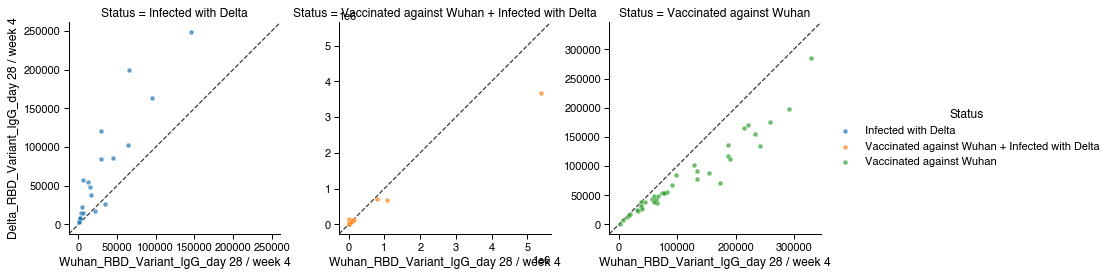

In [78]:
g = sns.FacetGrid(
    imprinting_df,
    col="Status",
    hue="Status",
    height=4,
    sharey=False,
    sharex=False,
)
g.map(sns.scatterplot, numerator_varname, denominator_varname, alpha=0.7)
for ax in g.axes_dict.values():
    ax.axline((0, 0), slope=1, color=".2", linestyle="--", zorder=0)

for ax in g.axes.flat:
    # Make square: https://stackoverflow.com/q/25497402/130164
    # Get min and max of both axes
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
g.add_legend()

genetools.plots.savefig(
    g.fig, f"{config.paths.output_dir}/imprinting_level.raw_values.png", dpi=72
)

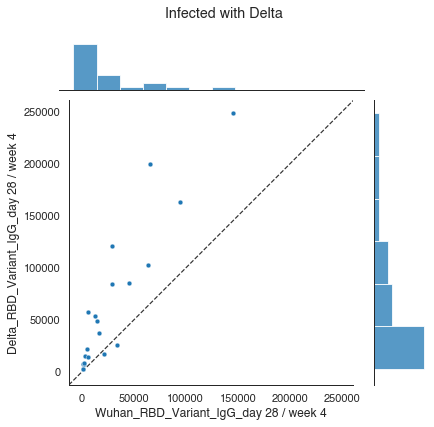

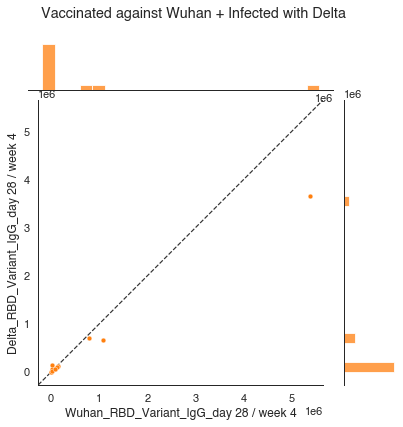

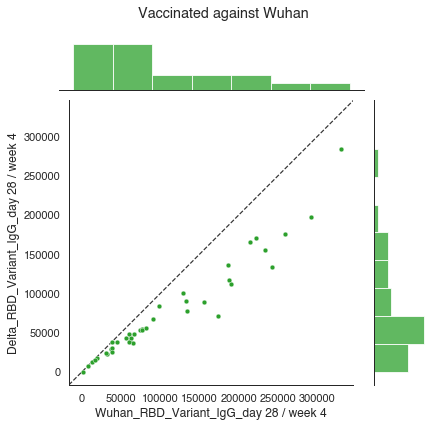

In [79]:
with sns.axes_style("white"):
    for (status, grp), color in zip(
        imprinting_df.groupby("Status", sort=False), sns.color_palette()
    ):
        g = sns.jointplot(
            data=grp,
            x=numerator_varname,
            y=denominator_varname,
            color=color,
        )
        ax = g.ax_joint
        ax.axline((0, 0), slope=1, color=".2", linestyle="--", zorder=0)

        # Make square: https://stackoverflow.com/q/25497402/130164
        # Get min and max of both axes
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.set_aspect("equal")
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(status)
        genetools.plots.savefig(
            g.fig,
            f"{config.paths.output_dir}/imprinting_level.raw_values.{slugify(status)}.png",
            dpi=72,
        )

### Plot raw ratios

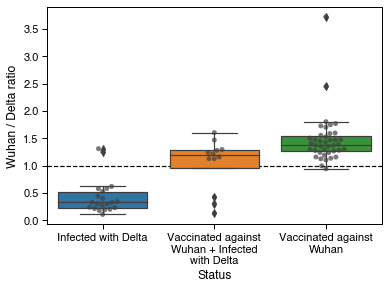

In [80]:
fig, ax = plt.subplots()
sns.boxplot(data=imprinting_df, x="Status", y="ratio", ax=ax)
sns.swarmplot(data=imprinting_df, x="Status", y="ratio", color=".25", alpha=0.7, ax=ax)

# Even preferences line
plt.axhline(y=1, color="k", zorder=-5, linestyle="dashed")

plt.ylabel("Wuhan / Delta ratio")

# wrap tick labels
genetools.plots.wrap_tick_labels(ax, wrap_x_axis=True, wrap_y_axis=False)

genetools.plots.savefig(
    fig, f"{config.paths.output_dir}/imprinting_level.raw_ratios.png", dpi=72
)

### Plot log transformed ratio

In [81]:
imprinting_df["ratio_log"] = np.log(imprinting_df["ratio"])
imprinting_df

,Status,ratio,Wuhan_RBD_Variant_IgG_day 28 / week 4,Delta_RBD_Variant_IgG_day 28 / week 4,ratio_log
VariantInfection_11,Infected with Delta,0.443932,16624.603516,37448.531250,-0.812084
VariantInfection_33,Infected with Delta,0.203085,1494.242676,7357.725098,-1.594131
VariantInfection_34,Infected with Delta,0.329469,65938.476562,200135.359375,-1.110272
VariantInfection_38,Infected with Delta,0.180084,2688.439453,14928.813477,-1.714332
VariantInfection_43,Infected with Delta,0.272468,2201.217041,8078.817871,-1.300235
...,...,...,...,...,...
pfizer48,Vaccinated against Wuhan,1.804002,242265.515625,134293.375000,0.590008
pfizer49,Vaccinated against Wuhan,1.239837,60149.832031,48514.312500,0.214980
pfizer55,Vaccinated against Wuhan,1.126029,17289.564453,15354.451172,0.118698
pfizer56,Vaccinated against Wuhan,1.297713,214266.906250,165111.218750,0.260603


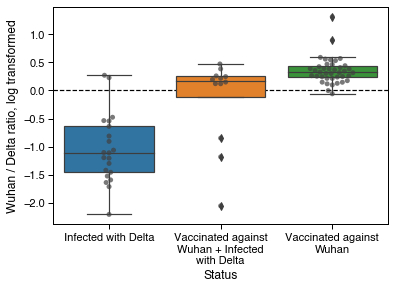

In [82]:
fig, ax = plt.subplots()

sns.boxplot(data=imprinting_df, x="Status", y="ratio_log", ax=ax)
sns.swarmplot(
    data=imprinting_df, x="Status", y="ratio_log", color=".25", alpha=0.7, ax=ax
)

# even preference line
plt.axhline(y=0, color="k", zorder=-5, linestyle="dashed")

# wrap tick labels
genetools.plots.wrap_tick_labels(ax, wrap_x_axis=True, wrap_y_axis=False)

plt.ylabel("Wuhan / Delta ratio, log transformed")

genetools.plots.savefig(
    fig, f"{config.paths.output_dir}/imprinting_level.log_ratios.png", dpi=72
)

In [83]:
imprinting_df["ratio_log"].describe()

count    73.000000
mean     -0.133897
std       0.775900
min      -2.209176
25%      -0.639939
50%       0.217850
75%       0.368859
max       1.314393
Name: ratio_log, dtype: float64

### Rescale log-transformed ratio, piecewise: -100%-0 and 0-100%

In [84]:
# ratio_log_rescaled
imprinting_df["Imprinting level"] = imprinting_df["ratio_log"].copy()
maximum_ratio_log = np.abs(imprinting_df["ratio_log"].max())
minimum_ratio_log = np.abs(imprinting_df["ratio_log"].min())
imprinting_df.loc[imprinting_df["ratio_log"] > 0, "Imprinting level"] = (
    imprinting_df.loc[imprinting_df["ratio_log"] > 0, "ratio_log"] / maximum_ratio_log
)
imprinting_df.loc[imprinting_df["ratio_log"] < 0, "Imprinting level"] = (
    imprinting_df.loc[imprinting_df["ratio_log"] < 0, "ratio_log"] / minimum_ratio_log
)
imprinting_df["Imprinting level"].describe()

count    73.000000
mean      0.010470
std       0.409912
min      -1.000000
25%      -0.289673
50%       0.165742
75%       0.280630
max       1.000000
Name: Imprinting level, dtype: float64

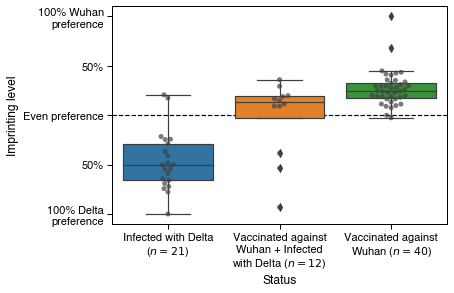

In [85]:
fig, ax = plt.subplots()
sns.boxplot(data=imprinting_df, x="Status", y="Imprinting level", ax=ax)
sns.swarmplot(
    data=imprinting_df, x="Status", y="Imprinting level", color=".25", alpha=0.7, ax=ax
)
plt.axhline(y=0, color="k", zorder=-5, linestyle="dashed")
plt.yticks(
    ticks=[-1, -0.5, 0, 0.5, 1],
    labels=[
        "100% Delta preference",
        "50%",
        "Even preference",
        "50%",
        "100% Wuhan preference",
    ],
)

# Add sample size to labels
ax.set_xticklabels(
    genetools.plots.add_sample_size_to_labels(
        labels=ax.get_xticklabels(), data=imprinting_df, hue_key="Status"
    )
)

# wrap tick labels
genetools.plots.wrap_tick_labels(ax, wrap_x_axis=True, wrap_y_axis=True)


# save rasterized
genetools.plots.savefig(
    fig, f"{config.paths.output_dir}/imprinting_level.log_rescaled_ratios.png", dpi=72
)
# save vector
genetools.plots.savefig(
    fig, f"{config.paths.output_dir}/imprinting_level.log_rescaled_ratios.pdf"
)

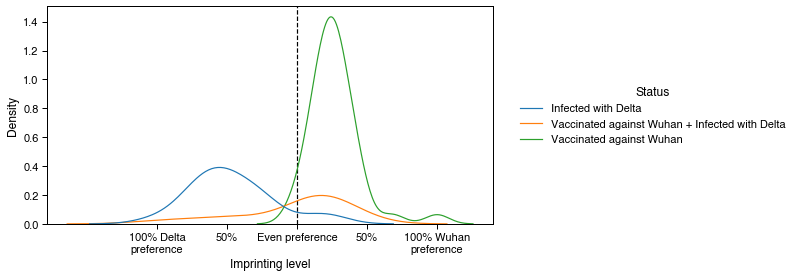

In [86]:
# Same but densities, overlapping

fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.kdeplot(
    data=imprinting_df, x="Imprinting level", hue="Status", ax=ax, legend=True
)
# Move legend -- need special way to extract legend for histplot or kdeplot: https://github.com/mwaskom/seaborn/issues/2280#issuecomment-899101193
# place legend outside figure
sns.move_legend(
    ax,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.0,
    # no border
    frameon=False,
    # transparent background
    framealpha=0.0,
)


plt.axvline(x=0, color="k", zorder=-5, linestyle="dashed")
plt.xticks(
    ticks=[-1, -0.5, 0, 0.5, 1],
    labels=[
        "100% Delta preference",
        "50%",
        "Even preference",
        "50%",
        "100% Wuhan preference",
    ],
)

# wrap tick labels
genetools.plots.wrap_tick_labels(ax, wrap_x_axis=True, wrap_y_axis=False)

genetools.plots.savefig(
    fig,
    f"{config.paths.output_dir}/imprinting_level.log_rescaled_ratios.densities.overlap.png",
    dpi=72,
)

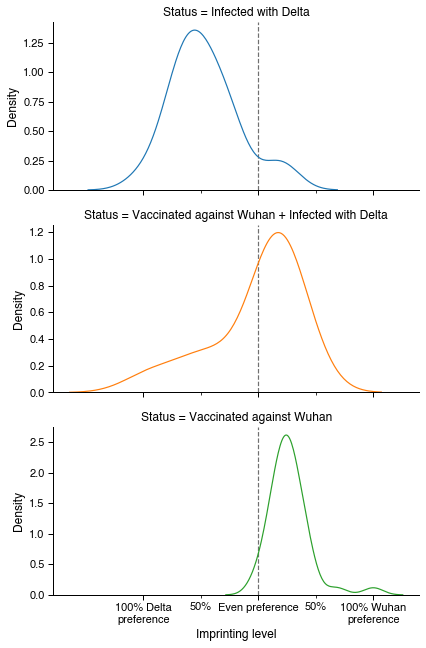

In [87]:
# Same but densities, stacked

g = sns.FacetGrid(
    imprinting_df, row="Status", hue="Status", sharey=False, sharex=True, aspect=2
)
g.map(sns.kdeplot, "Imprinting level")

for ax in g.axes.flat:
    ax.axvline(x=0, color=".2", zorder=-5, linestyle="dashed", alpha=0.7)

    ax.set_xticks(ticks=[-1, 0, 1], minor=False)
    ax.set_xticklabels(
        [
            "100% Delta preference",
            "Even preference",
            "100% Wuhan preference",
        ],
        minor=False,
    )

    ax.set_xticks(ticks=[-0.5, 0.5], minor=True)
    ax.set_xticklabels(
        [
            "50%",
            "50%",
        ],
        minor=True,
    )

    # wrap tick labels
    genetools.plots.wrap_tick_labels(ax, wrap_x_axis=True, wrap_y_axis=False)


# save rasterized
genetools.plots.savefig(
    g.fig,
    f"{config.paths.output_dir}/imprinting_level.log_rescaled_ratios.densities.stacked.png",
    dpi=72,
)
# save vector
genetools.plots.savefig(
    g.fig,
    f"{config.paths.output_dir}/imprinting_level.log_rescaled_ratios.densities.stacked.pdf",
)